In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import ray, multiprocessing
import scipy.io as sio
import ray, multiprocessing

num_cores = max(multiprocessing.cpu_count() - 1, 1)
ray.init(num_cpus=num_cores, ignore_reinit_error=True)
print(f"Ray initialized with {num_cores} cores for Modin.")

2025-11-16 11:52:53,035	INFO worker.py:1888 -- Started a local Ray instance.


Ray initialized with 11 cores for Modin.


In [5]:
dir_participant1 = "Localization/Participant1/"
dir_participant2 = "Localization/Participant2/"
lst_radar = ["103","108","109"]
str_pattern = "U"

Keys in Localization/Participant1/103/U/range_bins.mat: ['__header__', '__version__', '__globals__', 'Rbin_1033']


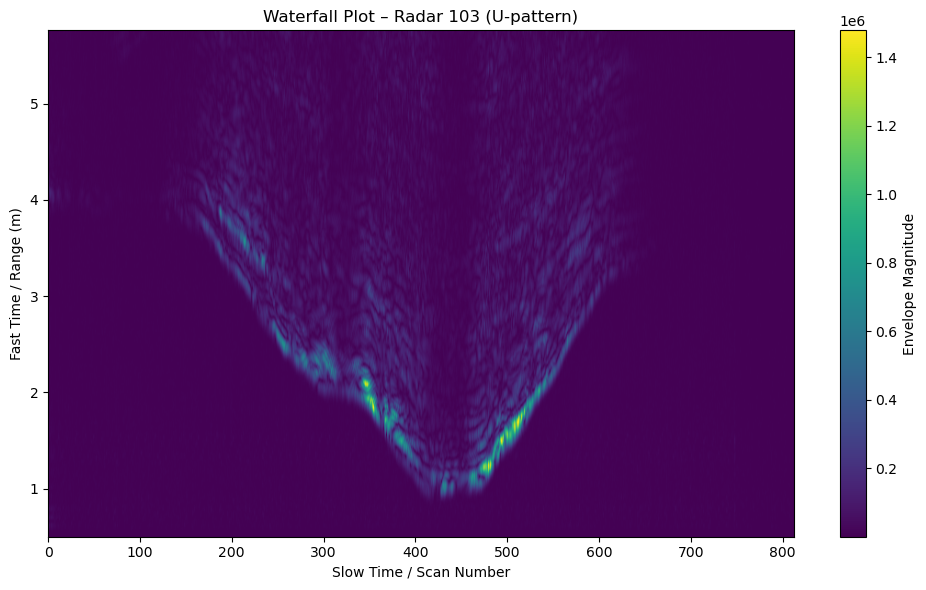

Keys in Localization/Participant1/108/U/range_bins.mat: ['__header__', '__version__', '__globals__', 'Rbin_103']


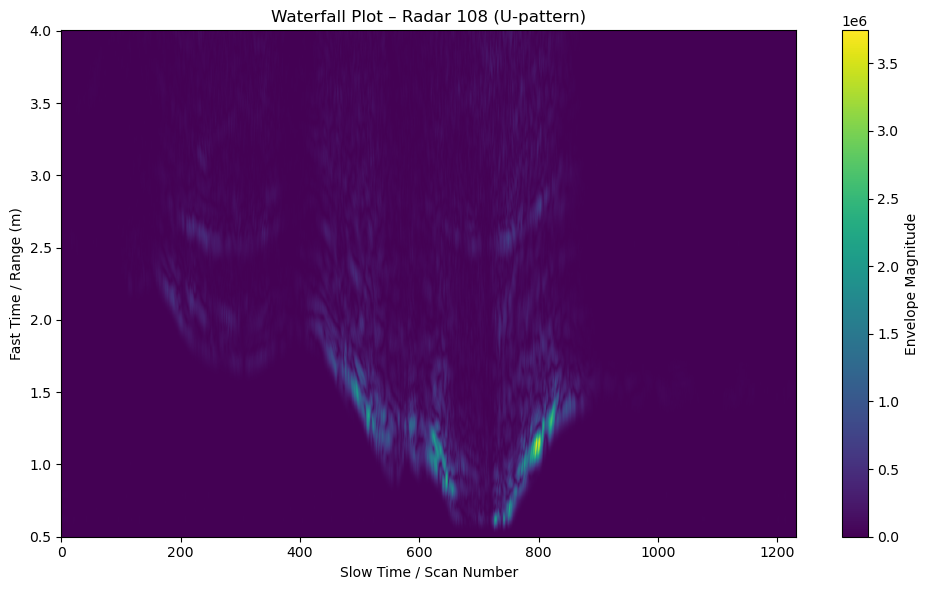

Keys in Localization/Participant1/109/U/range_bins.mat: ['__header__', '__version__', '__globals__', 'Rbin_102']


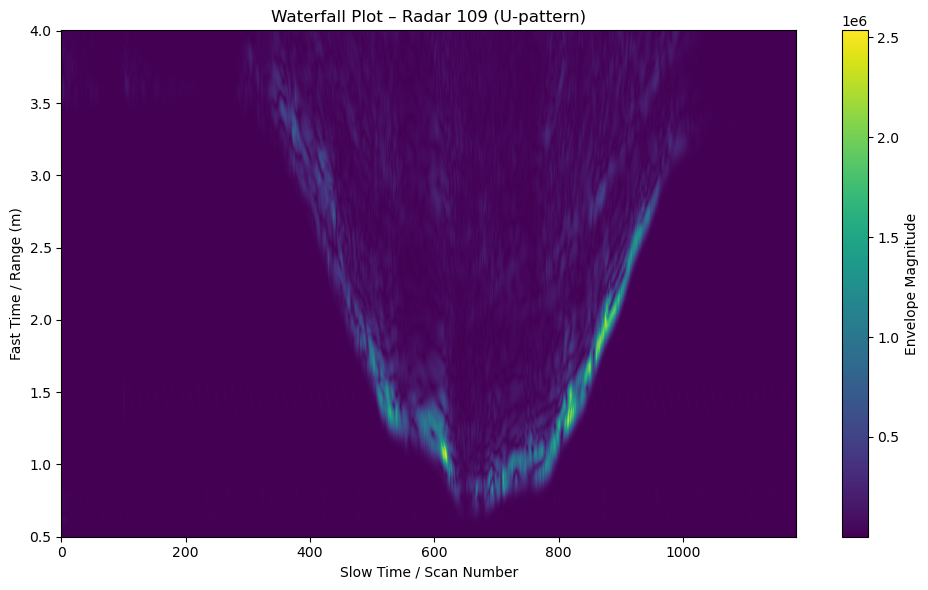

In [6]:
for r in lst_radar:
    fp_radarParticipant1 = os.path.join(dir_participant1, r, str_pattern)
    mat_file = os.path.join(fp_radarParticipant1, 'envNoClutterscans.mat')
    range_file = os.path.join(fp_radarParticipant1, 'range_bins.mat')

    mat_data = sio.loadmat(mat_file)
    env_key = [k for k in mat_data.keys() if 'env' in k.lower()]
    if not env_key:
        raise KeyError(f"No variable containing 'env' found in {mat_file}")
    env = mat_data[env_key[0]]

    # Load range_bins dynamically
    range_data = sio.loadmat(range_file)
    print(f"Keys in {range_file}: {list(range_data.keys())}")  # <— see what’s actually inside
    range_key = [k for k in range_data.keys() if 'range' in k.lower() or 'bin' in k.lower()]
    if not range_key:
        raise KeyError(f"No variable containing 'range' or 'bin' found in {range_file}")
    range_bins = np.squeeze(range_data[range_key[0]])

    # --- Visualization (Step 1) ---
    plt.figure(figsize=(10, 6))
    plt.imshow(
        env.T,
        aspect='auto',
        origin='lower',
        extent=[0, env.shape[0], range_bins[0], range_bins[-1]],
        cmap='viridis'
    )
    plt.colorbar(label='Envelope Magnitude')
    plt.xlabel('Slow Time / Scan Number')
    plt.ylabel('Fast Time / Range (m)')
    plt.title(f'Waterfall Plot – Radar {r} ({str_pattern}-pattern)')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_waterfall(
    participant_dir,
    radar_id,
    pattern,
    title_suffix="Participant 1",
    cmap="viridis"
):
    """
    Plot UWB envelope waterfall for a given participant, radar, and pattern.

    Parameters
    ----------
    participant_dir : str
        Base directory for the participant (e.g., "Localization/Participant1").
    radar_id : str or int
        Radar ID as "103", "108", or "109".
    pattern : str
        Walking pattern folder name (e.g., "U", "diag", "L", "gamma", "four").
    title_suffix : str, optional
        Extra text to append to the plot title (e.g., "Participant 1").
    cmap : str, optional
        Matplotlib colormap name.
    """

    radar_id = str(radar_id)
    fp_radar = os.path.join(participant_dir, radar_id, pattern)

    mat_file = os.path.join(fp_radar, "envNoClutterscans.mat")
    range_file = os.path.join(fp_radar, "range_bins.mat")

    # ---- Load envelope ----
    mat_data = sio.loadmat(mat_file)
    env_key = [k for k in mat_data.keys() if "env" in k.lower()]
    if not env_key:
        raise KeyError(f"No variable containing 'env' found in {mat_file}")
    env = mat_data[env_key[0]]

    # ---- Load range bins ----
    range_data = sio.loadmat(range_file)
    # print(f"Keys in {range_file}: {list(range_data.keys())}")  # optional debug
    range_key = [k for k in range_data.keys() if "range" in k.lower() or "bin" in k.lower()]
    if not range_key:
        raise KeyError(f"No variable containing 'range' or 'bin' found in {range_file}")
    range_bins = np.squeeze(range_data[range_key[0]])

    # ---- Waterfall plot ----
    plt.figure(figsize=(10, 6))
    plt.imshow(
        env.T,
        aspect="auto",
        origin="lower",
        extent=[0, env.shape[0], range_bins[0], range_bins[-1]],
        cmap=cmap,
    )
    plt.colorbar(label="Envelope Magnitude")
    plt.xlabel("Slow Time / Scan Number")
    plt.ylabel("Fast Time / Range (m)")
    plt.title(f"Waterfall Plot – Radar {radar_id} ({pattern}-pattern, {title_suffix})")
    plt.tight_layout()
    plt.show()

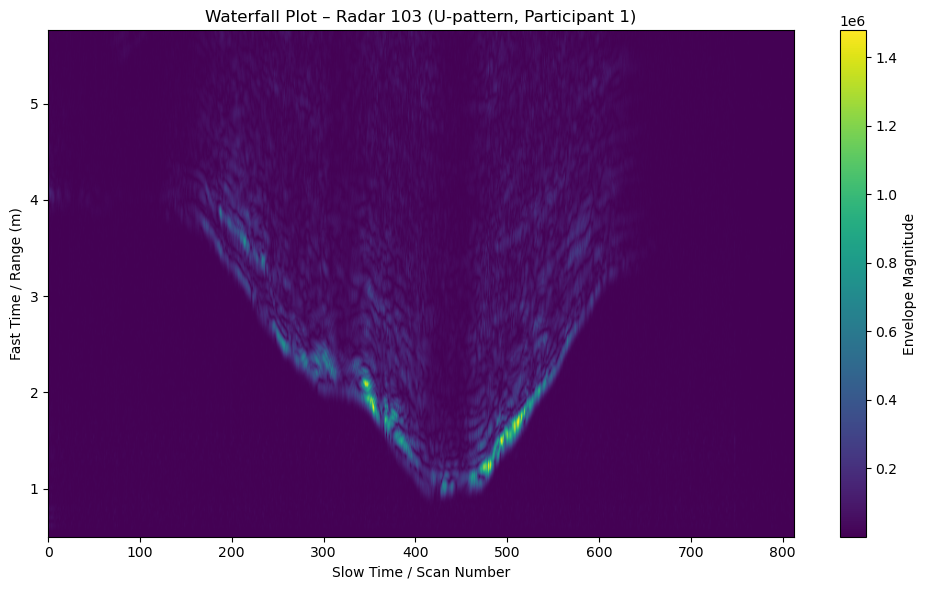

In [9]:
plot_waterfall(dir_participant1, "103", str_pattern, title_suffix="Participant 1")

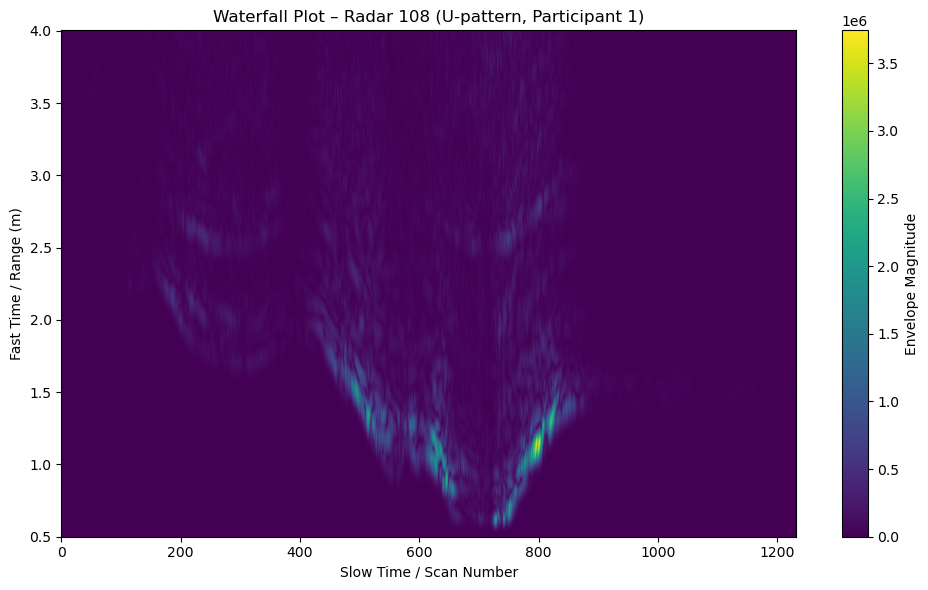

In [11]:
plot_waterfall(dir_participant1, "108",str_pattern, title_suffix="Participant 1")


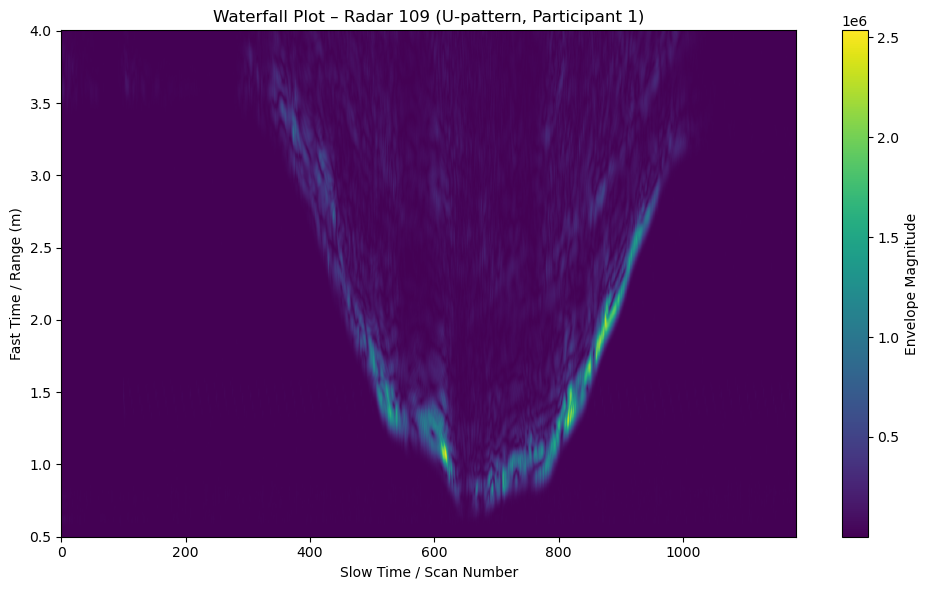

In [12]:
plot_waterfall(dir_participant1, "109", str_pattern, title_suffix="Participant 1")


In [17]:
def load_radar_data(participant_dir, radar_id, pattern):
    """
    Loads env (envelope), range_bins, and timestamps for a radar.
    """

    radar_id = str(radar_id)
    base = os.path.join(participant_dir, radar_id, pattern)

    env_file   = os.path.join(base, "envNoClutterscans.mat")
    range_file = os.path.join(base, "range_bins.mat")
    t_file     = os.path.join(base, "T_stmp.mat")

    # Load env
    env_mat = sio.loadmat(env_file)
    env_key = [k for k in env_mat.keys() if "env" in k.lower()]
    env = env_mat[env_key[0]]

    # Load range bins
    rmat = sio.loadmat(range_file)
    rkey = [k for k in rmat.keys() if "range" in k.lower() or "bin" in k.lower()]
    range_bins = np.squeeze(rmat[rkey[0]])

    # Load timestamps
    tmat = sio.loadmat(t_file)
    tkey = [k for k in tmat.keys() if "t" in k.lower()]
    t_stmp = np.squeeze(tmat[tkey[0]])

    return env, range_bins, t_stmp

In [23]:
env103, bins103, t103 = load_radar_data("Localization/Participant1", "103", "U")
env108, bins108, t108 = load_radar_data("Localization/Participant1", "108", "U")
env109, bins109, t109 = load_radar_data("Localization/Participant1", "109", "U")
env108, bins108, t108 


(array([[2.19904677e-01, 1.00845520e+02, 7.33265206e+02, ...,
         3.11782455e+04, 3.44495800e+04, 3.75209700e+04],
        [1.65707337e+00, 2.76239730e+01, 1.52198327e+02, ...,
         1.76428596e+04, 1.96245431e+04, 2.01175454e+04],
        [2.14407060e-01, 1.32994641e+01, 9.73682435e+01, ...,
         5.94155961e+03, 5.56808062e+03, 4.62844590e+03],
        ...,
        [3.81778954e-03, 6.94448933e+00, 5.68239447e+01, ...,
         1.67686177e+03, 1.71845666e+03, 1.57952834e+03],
        [2.90152005e-02, 2.22245558e+00, 1.72993109e+01, ...,
         3.49653320e+03, 2.91639720e+03, 2.21538793e+03],
        [4.19956849e-03, 1.07095481e+01, 8.02234160e+01, ...,
         1.70307481e+03, 1.93721595e+03, 1.99150688e+03]]),
 array([0.5       , 0.50914886, 0.51829773, 0.52744659, 0.53659546,
        0.54574432, 0.55489319, 0.56404205, 0.57319092, 0.58233978,
        0.59148865, 0.60063751, 0.60978638, 0.61893524, 0.62808411,
        0.63723297, 0.64638184, 0.6555307 , 0.66467957, 0.673

In [20]:
def plot_waterfall_from_env(env, range_bins, title="Waterfall", cmap="viridis"):
    """
    Plot UWB envelope waterfall from already loaded env + range_bins.
    """

    plt.figure(figsize=(10, 6))
    plt.imshow(
        env.T,
        aspect="auto",
        origin="lower",
        extent=[0, env.shape[0], range_bins[0], range_bins[-1]],
        cmap=cmap,
    )
    plt.colorbar(label="Envelope Magnitude")
    plt.xlabel("Slow Time / Scan Number")
    plt.ylabel("Fast Time / Range (m)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

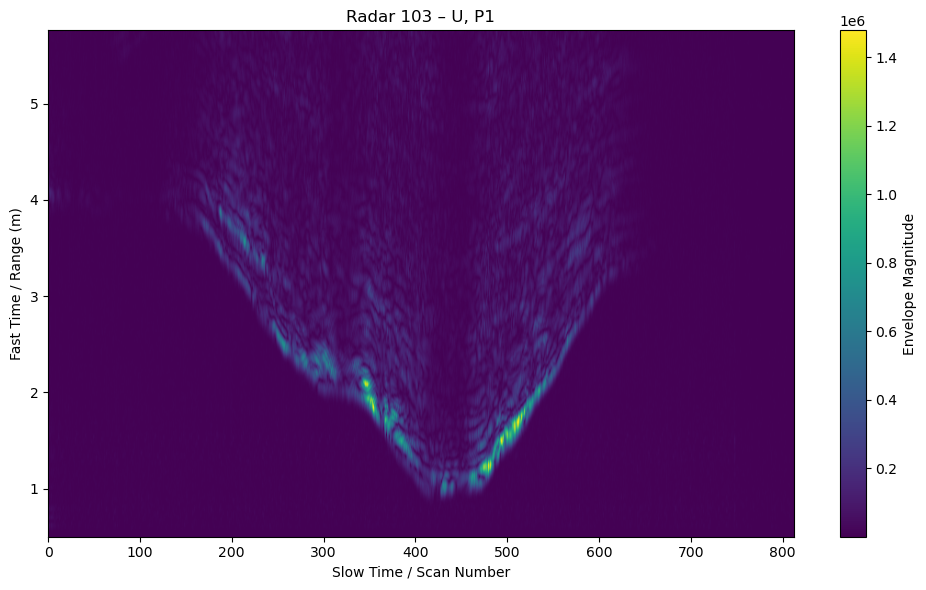

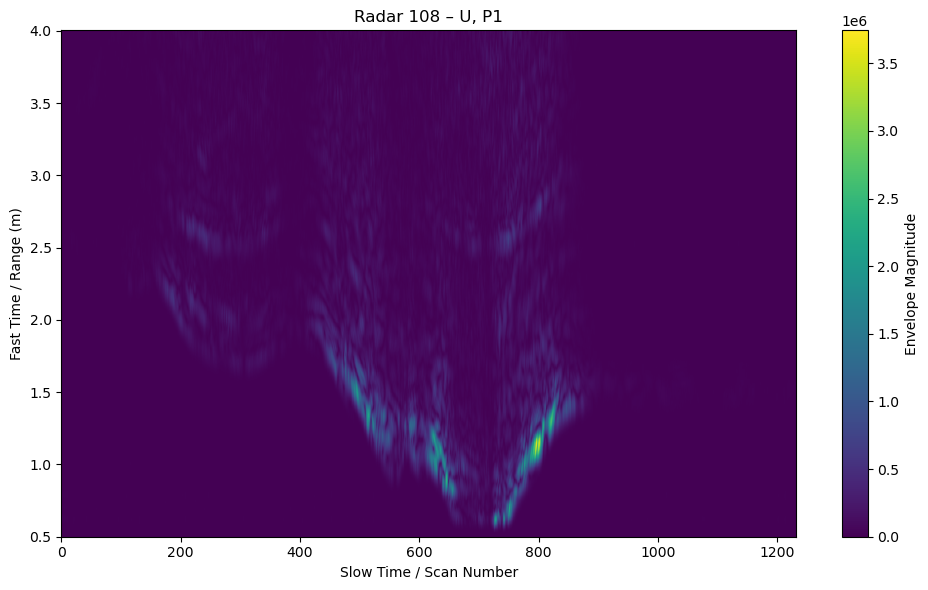

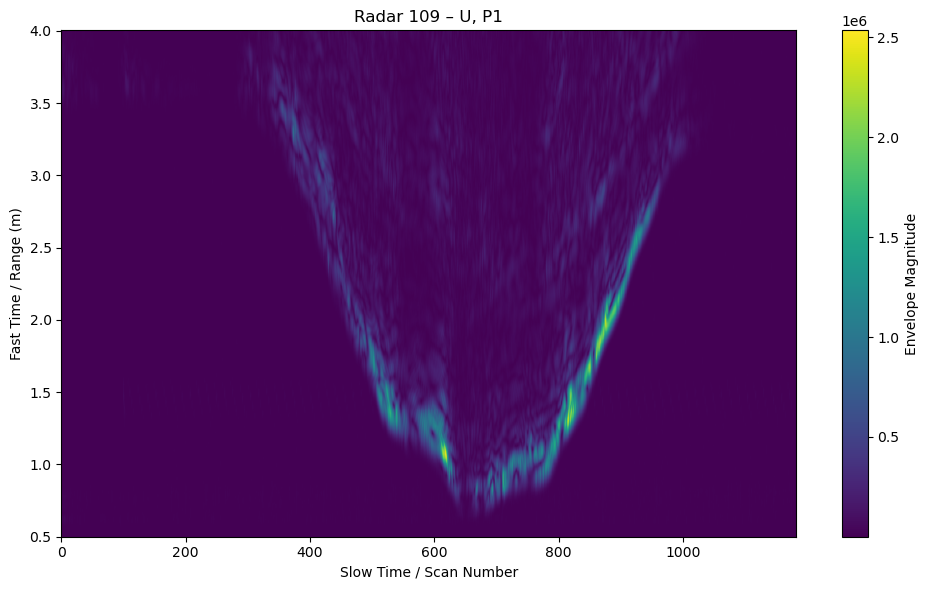

In [25]:
plot_waterfall_from_env(env103, bins103, title="Radar 103 – U, P1")
plot_waterfall_from_env(env108, bins108, title="Radar 108 – U, P1")
plot_waterfall_from_env(env109, bins109, title="Radar 109 – U, P1")


In [26]:
def get_radii_for_window(env, range_bins, timestamps, t_start, t_end, thresh=5e4):
    """
    Max-pools over scans in the window, thresholds, and returns selected radii.
    """
    mask = (timestamps >= t_start) & (timestamps <= t_end)
    idx = np.where(mask)[0]

    if idx.size == 0:
        return np.array([])

    env_window = env[idx, :]
    env_max = env_window.max(axis=0)

    active_bins = np.where(env_max > thresh)[0]

    if active_bins.size == 0:
        return np.array([])

    return range_bins[active_bins]

In [15]:
radii108 = get_radii_for_window(env108, bins108, t108, windows[0][0], windows[0][1])
radii108 


NameError: name 'env108' is not defined